In [10]:
from deltas import *
from training import *
import pandas as pd 

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

In [11]:
bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('egtm > 0')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('egtm > 0')

data = pd.concat([
    correct(bgu), 
    correct(bdu)
]).sort_values('reportts', ignore_index=True).drop(columns=['file_path', 'dep', 'arr'])

data.shape

(3771, 218)

In [12]:
acms_full = pd.read_csv(
  './data/neo_takeoff_202403260034.csv', 
  parse_dates=['reportts'], 
  low_memory=False
).drop(columns=['processedts']).sort_values('reportts', ignore_index=True)

In [13]:
data = add_egt_delta_to_dataset(data, fleet=fleet, early=True, acms_data=acms_full, interval=pd.to_timedelta('90D'))

2018-12-26 11:42:25 (26, 207)
2018-12-24 10:53:21 (301, 207)
2018-12-26 11:42:25 (27, 207)
2018-12-24 10:53:21 (300, 207)
2018-07-01 09:52:23 (55, 207)
2018-06-27 13:23:43 (295, 207)
2018-07-01 09:52:23 (58, 207)
2018-06-27 13:23:43 (292, 207)


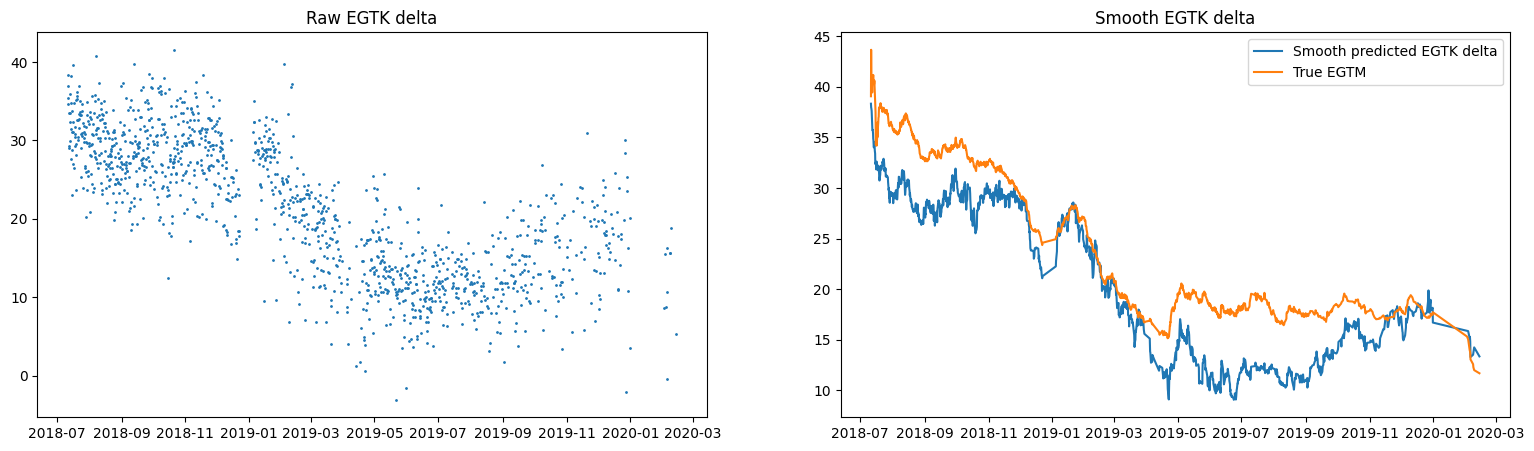

In [14]:
import matplotlib.pyplot as plt

sub = data.query('pos==2 and acnum=="VQ-BDU"')

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  sub['egt_delta'], s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(sub['egt_delta'], alpha=0.1))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

In [15]:
features_k = ['egt_delta_smooth', 'egtk', 't2', 'n1ak', 'alt', 'nfk', 'prv']

dataset = build_dataset(
  fleet,
  y_cols, 
  meta_cols, 
  features_k,
  n_back=12,
  data=data
)

In [16]:
from sklearn.linear_model import Ridge

def predict_boolean_ensemble(models: List[Ridge], X: pd.DataFrame, field='nai'):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for val in [True, False]:
    index = (X[field] == val)
    pred.loc[index, 'pred'] = models[val].predict(X[index])
  return pred

def filter_split_by_bool_field(X: pd.DataFrame, y: pd.DataFrame, field: str, value: bool):
  return X[X[field] == value], y[X[field] == value]

def train_boolean_ensemble_model(X, y, model = 'linreg', field = 'nai'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = dict()
  ensemble[True] = Ridge()
  ensemble[False] = Ridge()

  for val in [True, False]:
    X_train_f, y_train_f = filter_split_by_bool_field(X_train, y_train, field, val)
    ensemble[val].fit(X_train_f, y_train_f)
  
  predicted_train = predict_boolean_ensemble(ensemble, X_train, field)

  predicted_test = predict_boolean_ensemble(ensemble, X_test, field)

  return get_metrics(y_test, predicted_test), ensemble, predicted_train, predicted_test, train_i, y_test

In [17]:
X = dataset.drop(columns=(meta_cols + y_cols))
y = dataset['egtm']

metrics, prv_ensemble, predicted_train, predicted_test, train_i, y_test = \
  train_boolean_ensemble_model(X, y, field='prv')

print(f'PRV ensemble: {metrics}')

PRV ensemble: {'rmse': 1.63208, 'mae': 1.35277, 'r2': 0.52291, 'mape': 0.06765}


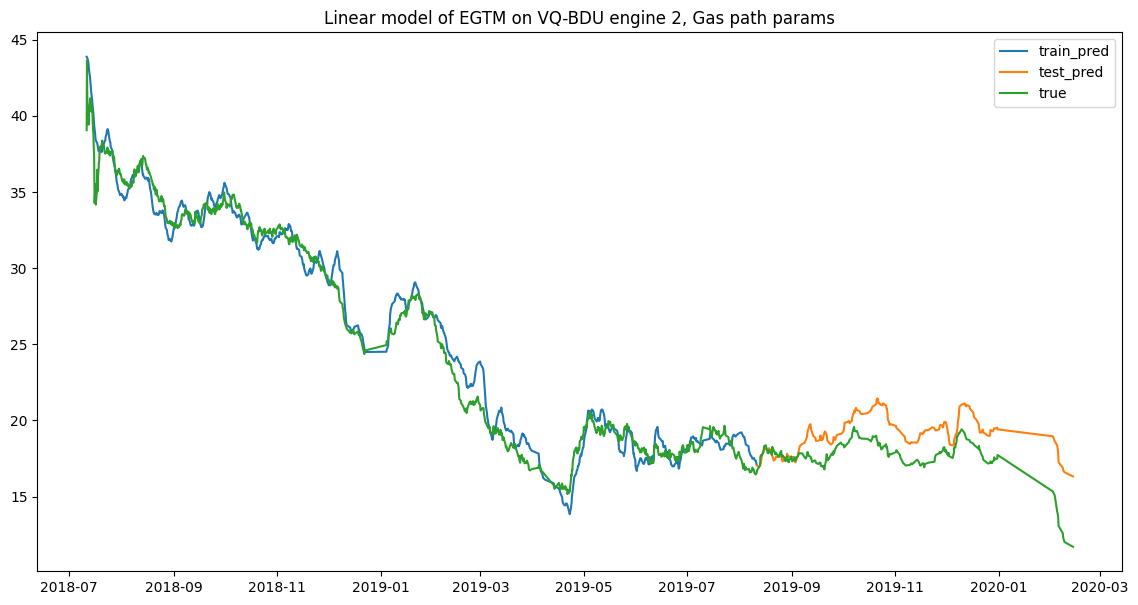

In [18]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.2)